在minist手写数字上训练hvae图像生成模型

In [1]:
import torch
import torchvision as tv
import torch.nn as nn
import torch.nn.functional as F


In [2]:
# 超参数定义
from dataclasses import dataclass


@dataclass
class Config:
    # 文件&数据
    data_path: str = "./dataset/mnist"
    save_dir: str = "./checkpoints"
    save_every: int = 10
    transform = tv.transforms.Compose([
        tv.transforms.ToTensor(),
        # tv.transforms.Normalize((0.5,), (0.5,))
    ])
    # 训练参数
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    batch_size: int = 1024
    num_workers: int = 4
    lr: float = 1e-4
    num_epochs: int = 300
    # 模型参数
    img_size = 28
    latent_dim1 = 32
    latent_dim2 = 32

g_opt = Config()

In [3]:
# 数据集
from torch.utils.data import DataLoader


train_dataset = tv.datasets.MNIST(
    root=g_opt.data_path,
    train=True,
    transform=g_opt.transform,
    download=True
)
test_dataset = tv.datasets.MNIST(
    root=g_opt.data_path,
    train=False,
    transform=g_opt.transform,
    download=True
)
print(f"共有{len(train_dataset)}张训练图片，{len(test_dataset)}张测试图片")
# 数据加载器
train_loader = DataLoader(
    train_dataset,
    batch_size=g_opt.batch_size,
    shuffle=True,
    num_workers=g_opt.num_workers
)
val_loader = DataLoader(
    test_dataset,
    batch_size=g_opt.batch_size,
    shuffle=False,
    num_workers=g_opt.num_workers
)


共有60000张训练图片，10000张测试图片


In [ ]:
# Utility
def save_images(tensor, fn, nrow=8, padding=2):
    """
    保存图像
    """
    grid = tv.utils.make_grid(tensor, nrow=nrow, padding=padding)
    tv.utils.save_image(grid, fn)

def kl_divergence_gaussians(q_mu, q_logvar, p_mu, p_logvar):
    """
    计算两个多元高斯分布之间的KL散度 D_KL(q || p)
    q: N(q_mu, exp(q_logvar))
    p: N(p_mu, exp(p_logvar))
    """
    q_std = torch.exp(0.5 * q_logvar)
    p_std = torch.exp(0.5 * p_logvar)
    
    # D_KL(q || p) = 0.5 * [ log(det(Sigma_p)/det(Sigma_q)) - k + tr(Sigma_p^-1 * Sigma_q) + (mu_p - mu_q)^T Sigma_p^-1 (mu_p - mu_q) ]
    # 对于对角协方差矩阵，公式简化为：
    kl_div = torch.sum(p_logvar - q_logvar - 1 + (q_std.pow(2) + (q_mu - p_mu).pow(2)) / p_std.pow(2), dim=1)
    
    return 0.5 * kl_div

def hvae_loss(x, x_recon, mu_q1, logvar_q1, mu_q2, logvar_q2, mu_p1, logvar_p1):
    # 1. 重构损失
    recon_loss = F.binary_cross_entropy(x_recon.view(-1, 784), x.view(-1, 784), reduction='sum')
    # 2. KL 散度 for z2
    # D_KL(q(z2|z1) || p(z2)), 其中 p(z2) ~ N(0, I)
    mu_p2 = torch.zeros_like(mu_q2)
    logvar_p2 = torch.zeros_like(logvar_q2)
    kl2 = kl_divergence_gaussians(mu_q2, logvar_q2, mu_p2, logvar_p2).sum()
    # 3. KL 散度 for z1
    # D_KL(q(z1|x) || p(z1|z2))
    kl1 = kl_divergence_gaussians(mu_q1, logvar_q1, mu_p1, logvar_p1).sum()
    batch_size = x.size(0)
    kl1 /= batch_size
    kl2 /= batch_size
    recon_loss /= batch_size
    return recon_loss + kl1 + kl2, recon_loss, kl1 + kl2


In [5]:
# HVAE Model
from typing import Tuple


class HVAE(nn.Module):
    def __init__(self, img_size=28, latent_dim1=20, latent_dim2=10):
        super(HVAE, self).__init__()
        self.img_size = img_size
        self.latent_dim1 = latent_dim1
        self.latent_dim2 = latent_dim2
        
        # --- 1. 推断模型 (Inference Model: q(z1|x), q(z2|z1)) ---
        
        # 1a. 从 x 提取特征
        self.encoder_base = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=1), # (B, 1, 28, 28) -> (B, 16, 14, 14)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1), # (B, 16, 14, 14) -> (B, 32, 7, 7)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # (B, 32, 7, 7) -> (B, 64, 4, 4)
            nn.ReLU(),
            nn.Flatten() # (B, 64*4*4=1024)
        )
        
        # 1b. 从特征推断 z1: q(z1|x)
        self.fc_q1_mu = nn.Linear(64 * 4 * 4, latent_dim1)
        self.fc_q1_logvar = nn.Linear(64 * 4 * 4, latent_dim1)
        
        # 1c. 从 z1 推断 z2: q(z2|z1)
        self.encoder_z2 = nn.Sequential(
            nn.Linear(latent_dim1, 128),
            nn.ReLU()
        )
        self.fc_q2_mu = nn.Linear(128, latent_dim2)
        self.fc_q2_logvar = nn.Linear(128, latent_dim2)
        # --- 2. 生成模型 (Generative Model: p(z1|z2), p(x|z1)) ---
        # 2a. 从 z2 生成 z1 的先验分布: p(z1|z2)
        self.decoder_p1 = nn.Sequential(
            nn.Linear(latent_dim2, 128),
            nn.ReLU()
        )
        self.fc_p1_mu = nn.Linear(128, latent_dim1)
        self.fc_p1_logvar = nn.Linear(128, latent_dim1)
        
        # 2b. 从 z1 重构 x: p(x|z1)
        self.decoder_input = nn.Linear(latent_dim1, 64 * 4 * 4)
        self.decoder_x = nn.Sequential(
            nn.Unflatten(1, (64, 4, 4)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1), # (B, 64, 4, 4) -> (B, 32, 7, 7)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1), # (B, 32, 7, 7) -> (B, 16, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1), # (B, 16, 14, 14) -> (B, 1, 28, 28)
            nn.Sigmoid(),
        )
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, ...]:
        # 推断 q(z1|x) 和 q(z2|z1)
        h = self.encoder_base(x)
        
        # q(z1|x)
        mu_q1 = self.fc_q1_mu(h)
        logvar_q1 = self.fc_q1_logvar(h)
        z1 = self.reparameterize(mu_q1, logvar_q1)
        
        # q(z2|z1)
        h2 = self.encoder_z2(z1)
        mu_q2 = self.fc_q2_mu(h2)
        logvar_q2 = self.fc_q2_logvar(h2)
        z2 = self.reparameterize(mu_q2, logvar_q2)
        
        return z1, mu_q1, logvar_q1, z2, mu_q2, logvar_q2
    def decode(self, z1: torch.Tensor, z2: torch.Tensor) -> Tuple[torch.Tensor, ...]:
        # 生成 p(z1|z2) 和 p(x|z1)
        
        # p(z1|z2)
        h_p1 = self.decoder_p1(z2)
        mu_p1 = self.fc_p1_mu(h_p1)
        logvar_p1 = self.fc_p1_logvar(h_p1)
        
        # p(x|z1)
        h_x = self.decoder_input(z1)
        x_recon = self.decoder_x(h_x)
        
        return x_recon, mu_p1, logvar_p1
    def forward(self, x: torch.Tensor):
        # 推断路径
        z1, mu_q1, logvar_q1, z2, mu_q2, logvar_q2 = self.encode(x)
        
        # 生成路径
        x_recon, mu_p1, logvar_p1 = self.decode(z1, z2)
        
        return x_recon, mu_q1, logvar_q1, mu_q2, logvar_q2, mu_p1, logvar_p1
        
    def sample(self, num_samples: int, device: torch.device):
        """从先验中采样生成新图像"""
        # 从顶层先验 p(z2) ~ N(0, I) 采样
        z2 = torch.randn(num_samples, self.latent_dim2).to(device)
        
        # 基于 z2 计算 p(z1|z2) 的参数
        h_p1 = self.decoder_p1(z2)
        mu_p1 = self.fc_p1_mu(h_p1)
        logvar_p1 = self.fc_p1_logvar(h_p1)
        
        # 从 p(z1|z2) 采样 z1
        z1 = self.reparameterize(mu_p1, logvar_p1)
        
        # 从 z1 生成图像
        h_x = self.decoder_input(z1)
        generated_x = self.decoder_x(h_x)
        
        return generated_x

In [6]:
from tqdm import tqdm

def train_epoch(model, train_loader, optimizer, device):
    model.train()
    train_loss, recon_loss, kld_loss = 0, 0, 0
    for x, y in train_loader:
        x = x.to(device)
        x_recon, mu_q1, logvar_q1, mu_q2, logvar_q2, mu_p1, logvar_p1 = model(x)
        loss, recon_loss, kld_loss = hvae_loss(x, x_recon, mu_q1, logvar_q1, mu_q2, logvar_q2, mu_p1, logvar_p1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        recon_loss += recon_loss.item()
        kld_loss += kld_loss.item()
        
    return train_loss/len(train_loader), recon_loss/len(train_loader), kld_loss/len(train_loader)

def val_epoch(model, val_loader, device):
    model.eval()
    with torch.no_grad():
        val_loss, recon_loss, kld_loss = 0, 0, 0
        for x, y in val_loader:
            x = x.to(device)
            x_recon, mu_q1, logvar_q1, mu_q2, logvar_q2, mu_p1, logvar_p1 = model(x)
            loss, recon_loss, kld_loss = hvae_loss(x, x_recon, mu_q1, logvar_q1, mu_q2, logvar_q2, mu_p1, logvar_p1)
            val_loss += loss.item()
            recon_loss += recon_loss.item()
            kld_loss += kld_loss.item()
            
    return val_loss/len(val_loader), recon_loss/len(val_loader), kld_loss/len(val_loader)

def train(model, train_loader, val_loader, optimizer, device, num_epochs):
    model.to(device)
    best_loss = float('inf')

    epoch_pbar = tqdm(range(num_epochs), desc="Epochs", position=0)

    for epoch in epoch_pbar:
        train_loss, _, _ = train_epoch(model, train_loader, optimizer, device)
        val_loss, recon_loss, kld_loss = val_epoch(model, val_loader, device)
        epoch_pbar.set_postfix(
            Train=f"{train_loss:.4f}",
            Test=f"{val_loss:.4f}",
            Recon=f"{recon_loss:.3f}",
            KLD=f"{kld_loss:.3f}"
        )
        # print(f"Epoch {epoch+1}/{num_epochs} TrainLoss: {train_loss:.4f} TestLoss: {val_loss:.4f} ReconLoss: {recon_loss:.3f} KLD: {kld_loss:.3f}")        
        cur_val_loss = val_loss
        # 保存最佳模型
        if cur_val_loss < best_loss:
            best_loss = cur_val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss
            }, f"{g_opt.save_dir}/best.pth")
            
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': cur_val_loss
        }, f"{g_opt.save_dir}/last.pth")

        # if epoch % g_opt.save_every == 0 or epoch == num_epochs - 1 or epoch == 0:
        #     save_epoch(model, val_loader, epoch, device, times=1)



In [7]:
model = HVAE(img_size=g_opt.img_size, latent_dim1=g_opt.latent_dim1, latent_dim2=g_opt.latent_dim2)
optimizer = torch.optim.Adam(model.parameters(), lr=g_opt.lr)
train(model, train_loader, val_loader, optimizer, g_opt.device, g_opt.num_epochs)

Epochs: 100%|██████████| 300/300 [03:24<00:00,  1.47it/s, KLD=4040.264, Recon=11891.041, Test=100400.2961, Train=102824.1690]


测试集图像重建效果：


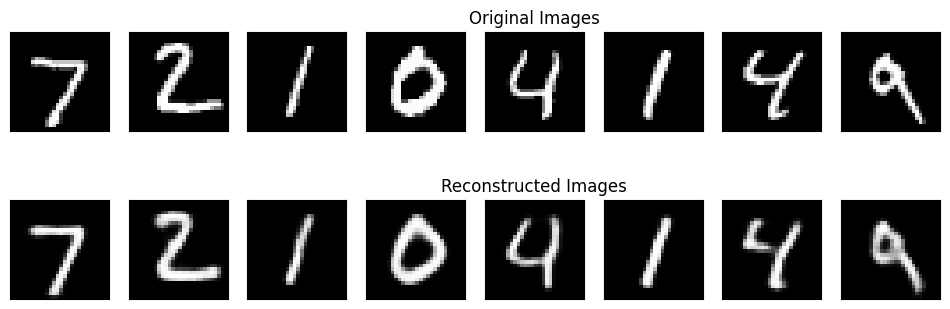

In [ ]:
import matplotlib.pyplot as plt
best_model = HVAE(img_size=g_opt.img_size, latent_dim1=g_opt.latent_dim1, latent_dim2=g_opt.latent_dim2)
best_model.load_state_dict(torch.load(f"{g_opt.save_dir}/best.pth")['model_state_dict'])
best_model.to(g_opt.device)
best_model.eval()

images, labels = next(iter(val_loader))
images = images.to(g_opt.device)

# 使用模型进行重建（不计算梯度）
with torch.no_grad():
    output = model(images)
    reconstructed_images = output[0]

images = images.cpu()
reconstructed_images = reconstructed_images.cpu()

def show_reconstructions(original, reconstructed, n=8):
    plt.figure(figsize=(12, 4))
    for i in range(n):
        # 显示原始图片
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Original Images')
        
        # 显示重建图片
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n // 2:
            ax.set_title('Reconstructed Images')
    plt.show()

# 展示前8张图片的重建效果
print("测试集图像重建效果：")
show_reconstructions(images, reconstructed_images, n=8)
